# Iranian Plate Detection
## Based on YOLO and Recurrent Neural Networks

## Requirements
- Pandas, Numpy
- Pytorch
- OpenCV
- imgaug

## Dataset

Plate Detection: A vehicle image dataset containing 3000+ samples [Download The Weight](https://github.com/alitourani/yolo-license-plate-detection)

OCR: A dataset with 83,000+ images of Farsi numbers and letters collected from real-world license plate images
[Download The Dataset](https://github.com/alitourani/Iranis-dataset)

## Loading and using images

In [1]:
from imgaug import augmenters as iaa
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import seaborn as sns
sns.set()
sns.set_style('dark')
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision
from random import randint
import cv2
import imutils

### Some configurations

In [2]:
# input images width
img_width = 64
# input images height
img_height = 64
# every image will be splited into <img_splits> parts
img_splits = 20
# maximum length of each word
word_max_len = 15
# device for tensors
# current version is sequential and GPU has not a significant effect
# I didn't test the model on GPU 
device = 'cpu' 

### Set dataset path

In [3]:
dataset_path = 'data/Iranis Dataset Files Resized 5/'
csv_words_path = 'data/FileLabel.csv'

### Creating dataset object
It is easier to define a dataset object for using data for Pytorch models

In [4]:
class PersianOCR(Dataset):
    """Persian Hand-Written dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        # read the csv file
        self.csv = pd.read_csv(csv_file)
    def __len__(self):
        return self.csv.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = os.path.join(self.root_dir,
                                self.csv.iloc[idx, 0])
        word = self.csv.iloc[idx, 1]
        image = io.imread(img_name)
        
        item = {'image': image, 'word': word}

        if self.transform:
            item = self.transform(item)

        return item

dataset = PersianOCR(csv_words_path, dataset_path)

### Checking the raw dataset
Take a look at some random words from dataset

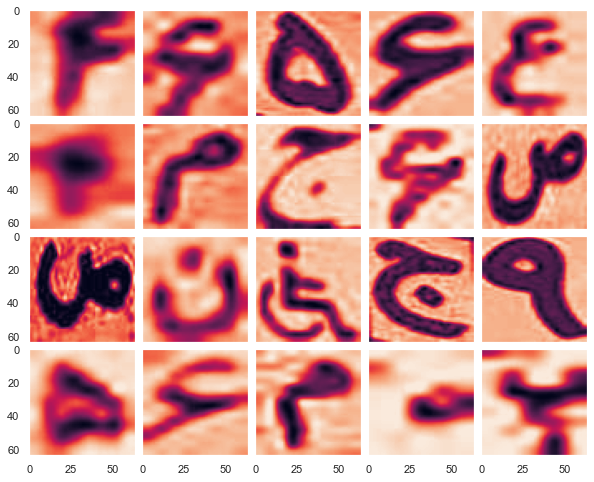

In [5]:
from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(figsize=(10., 12.))
grid = ImageGrid(fig, 111, nrows_ncols=(4, 5), axes_pad=0.1)

images = []
for _ in range(20):
  images.append(dataset[randint(0, len(dataset)-1)]['image'])

for ax, im in zip(grid, images):
    ax.imshow(im)
plt.show()

### Converting Words and Images to Pytorch Tensors
We should define all persian alphabets.
Also we define `S` as start token and `E` as end token and `-` as blank character which is used for CTCLoss that we wanna use and is different from space character.

In [6]:
# define all persian alphabets
pchars = "آ ا ب پ ت ث ج چ ح خ د ذ ر ز ژ س ش ص ض ط ظ ع غ ف ق ک گ ل م ن و ه ی ئ 0 1 2 3 4 5 6 7 8 9 D"
pchars = ['-',' ', 'S', 'E'] + pchars.split(' ')
letter_to_index = {}
for i in range(len(pchars)):
  letter_to_index[pchars[i]] = i
enc_dim = len(pchars)

In [7]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, sample):
        image, word = sample['image'], sample['word']
        image = image.reshape(-1, img_height, img_width)
        if (len(word) > word_max_len):
          word = word[:word_max_len]
        word = word + 'E'
        original_word = [[letter_to_index[c]] for c in word]
        return {'image': torch.from_numpy(image).double(),
                'word' : torch.LongTensor(original_word)}

### Augmentation Pipeline
using imgaug we can define an Augmentation pipeline. It helps to train a robust model and useable for more realistic data. It randomly applies some of 5 augmentations.

In [8]:
class ImageAug(object):
    """Apply Image Augmentation on style and output"""

    def __call__(self, sample):
        image, word = sample['image'], sample['word']
        aug = iaa.SomeOf((0, 5), [
            iaa.Affine(scale={"x": (0.80, 1.20), "y": (0.80, 1.20)}),
            iaa.Affine(translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}),
            iaa.Add((-30, 30)),
            iaa.Multiply((0.80, 1.20)),
            iaa.GaussianBlur(sigma=(0, 0.2))
        ])
        image = aug(images=image)
        return {'image': image,
                'word': word}


### Create Dataset with Transformations

In [9]:
transformed_dataset = PersianOCR(csv_words_path, dataset_path,
                                 transform=transforms.Compose([ImageAug(), ToTensor()]))

dataloader = DataLoader(transformed_dataset, batch_size=1, shuffle=True)

### See some samples from transformed dataset

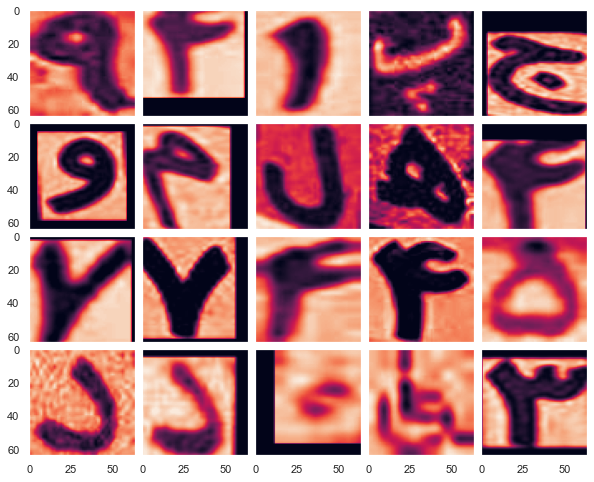

In [10]:
dataiter = iter(dataloader)

fig = plt.figure(figsize=(10., 12.))
grid = ImageGrid(fig, 111, nrows_ncols=(4, 5), axes_pad=0.1)

images = []
for _ in range(20):
  batch = dataiter.next()
  images.append(batch['image'][0][0])

for ax, im in zip(grid, images):
    ax.imshow(im)

plt.show()

## Defining a Recurrent Neural Network in Pytorch

In [11]:
import torch.nn as nn

class OCRNet(nn.Module):
    def __init__(self, img_size, hidden_size):
        super(OCRNet, self).__init__()
        self.hidden_size = hidden_size
        self.img_size = img_size
        self.enc_img_size = 200
        self.fc1 = nn.Linear(self.img_size, 450)
        self.fc2 = nn.Linear(450, self.enc_img_size)
        self.drop = nn.Dropout(p=0.1)
        self.act = nn.CELU()
        self.i2h = nn.Linear(self.enc_img_size + enc_dim + self.hidden_size, 80)
        self.h2h = nn.Linear(80, 60)
        self.h2h2 = nn.Linear(60, self.hidden_size)
        self.i2o = nn.Linear(self.enc_img_size + enc_dim + self.hidden_size, 200)
        self.o2o = nn.Linear(200, enc_dim)
        self.softmax = nn.LogSoftmax(dim=1)
    def forward(self, x, input, hidden):
        x = x.reshape((1, -1))
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.drop(x)
        combined = torch.cat((x, input.view((1, -1)), hidden.view((1, -1))), 1)
        hidden = self.act(self.i2h(combined))
        hidden = self.act(self.h2h(hidden))
        hidden = self.h2h2(hidden)
        output = self.act(self.i2o(combined))
        output = self.o2o(output)
        output = self.softmax(output)
        
        return output, hidden


ocr_net = OCRNet(int(img_width/img_splits)*img_height, enc_dim).double()
ocr_net = ocr_net.to(device)
print(ocr_net)
print("Number of Parameters: ", sum(p.numel() for p in ocr_net.parameters() if p.requires_grad))

OCRNet(
  (fc1): Linear(in_features=192, out_features=450, bias=True)
  (fc2): Linear(in_features=450, out_features=200, bias=True)
  (drop): Dropout(p=0.1, inplace=False)
  (act): CELU(alpha=1.0)
  (i2h): Linear(in_features=298, out_features=80, bias=True)
  (h2h): Linear(in_features=80, out_features=60, bias=True)
  (h2h2): Linear(in_features=60, out_features=49, bias=True)
  (i2o): Linear(in_features=298, out_features=200, bias=True)
  (o2o): Linear(in_features=200, out_features=49, bias=True)
  (softmax): LogSoftmax(dim=1)
)
Number of Parameters:  278468


## Training The Model

### Generating start token

In [12]:
def get_start_token():
  start_token = torch.zeros((1, enc_dim), dtype=torch.double).to(device)
  start_token[0][letter_to_index['S']] = 1
  return start_token

### Defining Optimizer

In [13]:
import torch.optim as optim

# I suggest to decrease the learning rate after each epoch
# for the first one I used lr = 0.0002 and for the second lr = 0.00005
optim_learning_rate = 0.0002

criterion = nn.CTCLoss() 
optimizer = optim.Adam(ocr_net.parameters(), lr=optim_learning_rate, betas=(0.5, 0.999))

epochs = 1
mini_batchs = 100
loss_values = []

### Training
After two epochs I saw an acceptable output. on CPU each epoch might take 1-2 hours.

In [14]:
ocr_net.train()
step = int(img_width / img_splits)
input_seq_len = torch.tensor([img_splits], dtype=torch.long)
for epoch in range(epochs):
    loss = 0
    mini_batch_loss = 0
    for i, data in enumerate(dataloader, 0):
        # get the input
        image, word = data['image'], data['word']
        image = image.to(device)
        word = word.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # initialize the RNN hidden state
        hidden = torch.zeros((1, enc_dim)).double().to(device)
        output = get_start_token()
        letters = []
        for j in range(img_splits):
          output, hidden = ocr_net(image[:, :, :,
                                     step*(img_splits-j-1):step*(img_splits-j)],
                                     output, hidden)
          letters.append(output)

        # concatinate the outputs
        predicted_word = torch.cat(letters, dim=1).view(img_splits, 1, enc_dim)
        
        target_seq_len = torch.tensor([word.size(1)],
                                      dtype=torch.long)
        
        # compairing the output and word based on CTCLoss
        loss = criterion(predicted_word, word.view((1, -1)),
                          input_seq_len, target_seq_len)
        
        loss.backward()
        
        optimizer.step()
        
        mini_batch_loss += loss.item()
        
        if i % mini_batchs == (mini_batchs-1):
            
            print('[%d, %5d] loss: %.5f' %
                  (epoch + 1, i + 1, mini_batch_loss/mini_batchs))
            
            loss_values.append(mini_batch_loss)    
        
            mini_batch_loss = 0

[1,   100] loss: 6.25864
[1,   200] loss: 2.53784
[1,   300] loss: 2.13988
[1,   400] loss: 2.04837
[1,   500] loss: 1.85325
[1,   600] loss: 1.91273
[1,   700] loss: 1.76282
[1,   800] loss: 1.78055
[1,   900] loss: 1.68101
[1,  1000] loss: 1.69697
[1,  1100] loss: 1.68992
[1,  1200] loss: 1.60279
[1,  1300] loss: 1.68556
[1,  1400] loss: 1.62883
[1,  1500] loss: 1.69002
[1,  1600] loss: 1.70971
[1,  1700] loss: 1.67194
[1,  1800] loss: 1.61922
[1,  1900] loss: 1.61059
[1,  2000] loss: 1.58138
[1,  2100] loss: 1.59468
[1,  2200] loss: 1.62413
[1,  2300] loss: 1.66101
[1,  2400] loss: 1.55931
[1,  2500] loss: 1.56771
[1,  2600] loss: 1.57899
[1,  2700] loss: 1.60385
[1,  2800] loss: 1.57192
[1,  2900] loss: 1.49275
[1,  3000] loss: 1.59663
[1,  3100] loss: 1.58007
[1,  3200] loss: 1.52324
[1,  3300] loss: 1.55653
[1,  3400] loss: 1.51712
[1,  3500] loss: 1.60021
[1,  3600] loss: 1.59071
[1,  3700] loss: 1.58137
[1,  3800] loss: 1.56865
[1,  3900] loss: 1.54420
[1,  4000] loss: 1.58501


KeyboardInterrupt: 

### Checking The Loss values

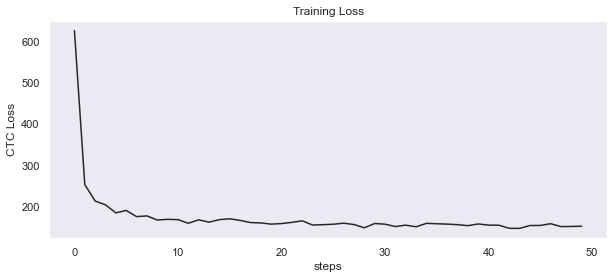

In [15]:
sns.set_palette(sns.dark_palette("purple"))
fig, ax = plt.subplots(figsize=(10, 4))
plot = sns.lineplot(ax=ax,y=loss_values, x=range(len(loss_values)))
plot.set_title("Training Loss")
plot.set_xlabel("steps")
plot.set_ylabel("CTC Loss")
plt.show()

## Using The Model for converting a page

### Cleaning The Ouput
Due to the CTCLoss we should clear the ouput from repeated characters then `-` (blank) characters. 

In [16]:
import re
def clean_ctc(s):
    # remove repeated
    word = ""
    prev = ""
    for c in s:
      if(c != prev):
        word += c
      prev = c
    word = re.sub('[\-SE]', '', word)
    return word

### Converting Output Tensor To Word

In [17]:
def tensor_to_word(word_tensor):
    word_tensor = word_tensor.max(2)[1].view(-1)
    word = ""
    for i in range(word_tensor.size(0)):
      word += pchars[word_tensor[i]]
    return clean_ctc(word)

### Transforming Numpy Images for evaluation

In [18]:
def transform_numpy_image(img):
    # scale the image
    # img = img.reshape(1, 1, 50, 100)
    img = img.reshape(1, 1, 64, 64)
    tensor = torch.from_numpy(img).double().to(device)
    return tensor

### Feeding Image to Model 

In [19]:
def image_to_word(img):
    tensor = transform_numpy_image(img)
    prediction = None
    ocr_net.eval()
    with torch.no_grad():
      hidden = torch.zeros((1, enc_dim)).double().to(device)
      output = get_start_token()
      letters = []
      for j in range(img_splits):
        step = int(img_width / img_splits)
        output, hidden = ocr_net(tensor[:, :, :, step*(img_splits-j-1):step*(img_splits-j)], output, hidden)
        letters.append(output)
      prediction = torch.cat(letters, dim=0).view(img_splits, 1, enc_dim)
    return tensor_to_word(prediction)

## Detect plate with YOLO

### Initialize the parameters

In [20]:
confThreshold = 0.5  # Confidence threshold
nmsThreshold = 0.4  # Non-maximum suppression threshold

inpWidth = 416  # 608     # Width of network's input image
inpHeight = 416  # 608     # Height of network's input image

### Load names of classes

In [21]:

classesFile = "classes.names"
classes = None
with open(classesFile, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')

### Give the configuration and weight files for the model and load the network using them.

In [22]:


modelConfiguration = "darknet-yolov3.cfg"
modelWeights = "weights/model/model.weights"

net = cv2.dnn.readNetFromDarknet(modelConfiguration, modelWeights)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

### Get the names of the output layers

In [23]:
def getOutputsNames(net):
    # Get the names of all the layers in the network
    layersNames = net.getLayerNames()
    # Get the names of the output layers, i.e. the layers with unconnected outputs
    return [layersNames[i[0] - 1] for i in net.getUnconnectedOutLayers()]

### Draw the predicted bounding box

In [24]:
def drawPred(img, classId, conf, left, top, right, bottom):
    # Draw a bounding box.
    #    cv.rectangle(img, (left, top), (right, bottom), (255, 178, 50), 3)
    cv2.rectangle(img, (left, top), (right, bottom), (0, 255, 0), 3)

    label = '%.2f' % conf

    # Get the label for the class name and its confidence
    if classes:
        assert(classId < len(classes))
        label = '%s: %s' % (classes[classId], label)

    # Display the label at the top of the bounding box
    labelSize, baseLine = cv2.getTextSize(
        label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    top = max(top, labelSize[1])
    cv2.rectangle(img, (left, top - round(1.5*labelSize[1])), (left + round(
        1.5*labelSize[0]), top + baseLine), (255, 0, 255), cv2.FILLED)
    #cv.rectangle(img, (left, top - round(1.5*labelSize[1])), (left + round(1.5*labelSize[0]), top + baseLine),    (255, 255, 255), cv.FILLED)
    cv2.putText(img, label, (left, top),
               cv2.FONT_HERSHEY_SIMPLEX, 0.70, (255, 255, 255), 2)

### Remove the bounding boxes with low confidence using non-maxima suppression

In [25]:
def postprocess(img, outs):
    imgHeight = img.shape[0]
    imgWidth = img.shape[1]

    classIds = []
    confidences = []
    boxes = []
    # Scan through all the bounding boxes output from the network and keep only the
    # ones with high confidence scores. Assign the box's class label as the class with the highest score.
    classIds = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            # if detection[4]>0.001:
            scores = detection[5:]
            classId = np.argmax(scores)
            # if scores[classId]>confThreshold:
            confidence = scores[classId]
            if detection[4] > confThreshold:
                print(detection[4], " - ", scores[classId],
                      " - th : ", confThreshold)
                print(detection)
            if confidence > confThreshold:
                center_x = int(detection[0] * imgWidth)
                center_y = int(detection[1] * imgHeight)
                width = int(detection[2] * imgWidth)
                height = int(detection[3] * imgHeight)
                left = int(center_x - width / 2)
                top = int(center_y - height / 2)
                classIds.append(classId)
                confidences.append(float(confidence))
                boxes.append([left, top, width, height])

    # Perform non maximum suppression to eliminate redundant overlapping boxes with
    # lower confidences.
    indices = cv2.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)
    plates = []
    for i in indices:
        i = i[0]
        box = boxes[i]
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
        plate = np.array(img[top:top+height, left:left+width])
        plates.append(plate)
        drawPred(img, classIds[i], confidences[i], left,
                 top, left + width, top + height)

    return plates

### Detect The Plate

In [26]:
def detect_plate(img):
    # Create a 4D blob from a img.
    blob = cv2.dnn.blobFromImage(
        img, 1/255, (inpWidth, inpHeight), [0, 0, 0], 1, crop=False)

    # Sets the input to the network
    net.setInput(blob)

    # Runs the forward pass to get output of the output layers
    outs = net.forward(getOutputsNames(net))

    # Remove the bounding boxes with low confidence
    plates = postprocess(img, outs)

    # Put efficiency information. The function getPerfProfile returns the overall time for inference(t) and the timings for each of the layers(in layersTimes)
    t, _ = net.getPerfProfile()
    label = 'Inference time: %.2f ms' % (t * 1000.0 / cv2.getTickFrequency())
    cv2.putText(img, label, (0, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))

    return img , plates

### Reading The Image

In [27]:
image_path = 'Car.jpg'
base_image = cv2.imread(image_path)
base_image = cv2.cvtColor(base_image, cv2.COLOR_BGR2RGB)

0.99994564  -  0.99991715  - th :  0.5
[0.4789645  0.58708125 0.13489296 0.05468142 0.99994564 0.99991715]
0.99971384  -  0.99948364  - th :  0.5
[0.48190838 0.5876165  0.13609126 0.05395057 0.99971384 0.99948364]


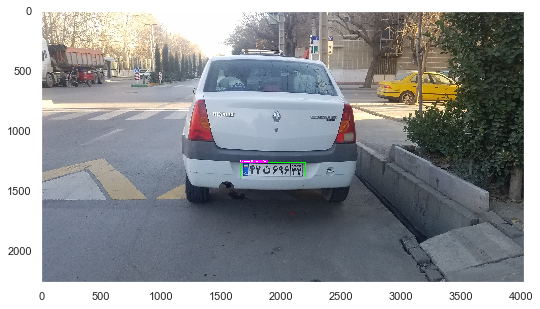

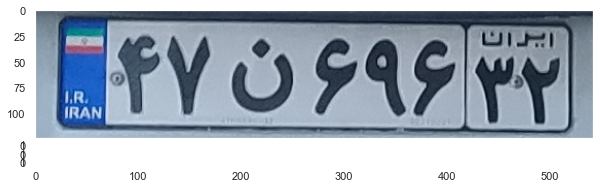

In [28]:
img_detected, plates = detect_plate(base_image)
fig, ax = plt.subplots(figsize=(14, 5))
ax.imshow(img_detected, interpolation='nearest')

if(len(plates)>0):
    fig = plt.figure(figsize=(10., 12.))
    grid = ImageGrid(fig, 111, nrows_ncols=(4, len(plates)), axes_pad=0.1)
    for ax, im in zip(grid, plates):
        ax.imshow(im)

### Reading The first plate Image

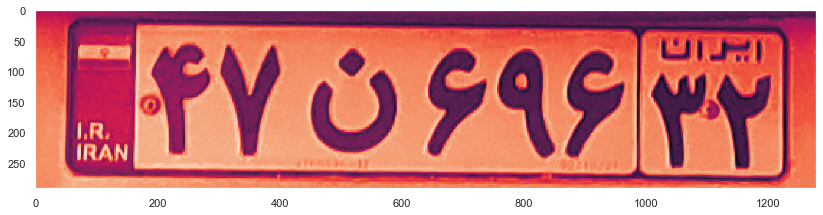

In [29]:
%matplotlib inline

if(len(plates)>0):
    img = plates[0]

    img = imutils.resize(img, width=1280)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    fig, ax = plt.subplots(figsize=(14, 5))
    ax.imshow(gray, interpolation='nearest')
else:
    print("Plate Not Found!")

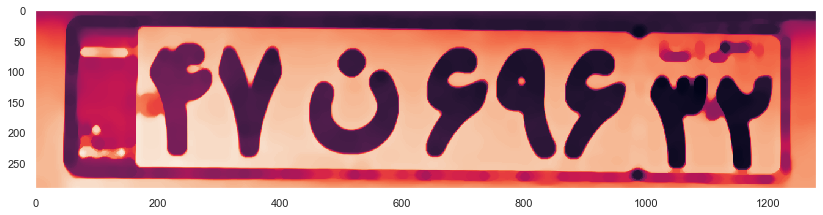

In [30]:

gray = cv2.fastNlMeansDenoisingColored(img,None,15,15,7,21)

gray =  cv2.cvtColor(gray,cv2.COLOR_BGR2GRAY)
gray = cv2.bilateralFilter(gray, 13, 15, 15)
kernel = np.ones((9,9),np.uint8)
edges = cv2.dilate(gray,kernel,iterations = 1)
kernel = np.ones((15,15),np.uint8)
gray = cv2.erode(edges,kernel,iterations = 1)

gray = cv2.medianBlur(gray,13)


fig, ax = plt.subplots(figsize=(14, 5))
ax.imshow(gray, interpolation='nearest')

### Thresholding The Image

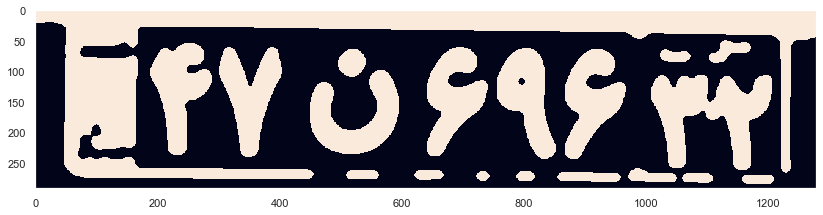

In [31]:
ret,thresh = cv2.threshold(gray, 0, 255,cv2.THRESH_OTSU|cv2.THRESH_BINARY_INV)
fig, ax = plt.subplots(figsize=(14, 5))
ax.imshow(thresh, interpolation='nearest')

### Using dilation to segment the words

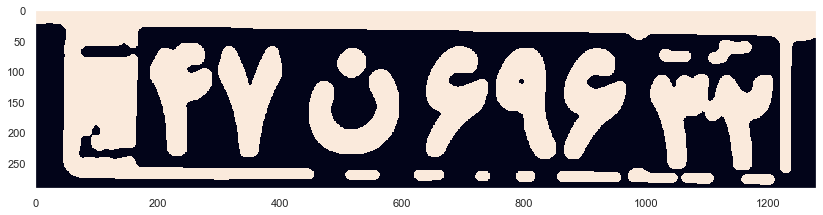

In [32]:
rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
dilation = cv2.dilate(thresh, rect_kernel, iterations = 1)
fig, ax = plt.subplots(figsize=(14, 5))
ax.imshow(dilation, interpolation='nearest')

### Finding The Contours

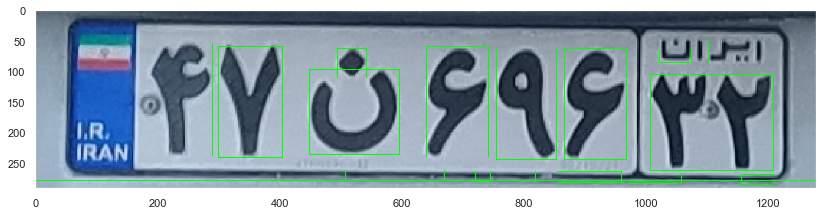

In [33]:
contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
img_contours = img.copy()
for cnt in contours:
  x, y, w, h = cv2.boundingRect(cnt)
  cv2.rectangle(img_contours, (x, y), (x + w, y + h), (0, 255, 0), 1)
fig, ax = plt.subplots(figsize=(14, 5))
ax.imshow(img_contours, interpolation='nearest')

### Sorting The Contours

In [34]:
from functools import cmp_to_key

def rectCmp(r1, r2):
  if (abs(r1[1] - r2[1]) < 20):
    return r2[0] - r1[0]
  return r1[1] - r2[1]

bounding_rects = [ cv2.boundingRect(c) for c in contours ]
bounding_rects.sort(key=cmp_to_key(rectCmp))

### Extract Images

In [35]:
def extract_images(rects, image):
  images = []
  for r in rects:
    x, y, w, h = r
    H=64
    W=64
    Y = int((H-h)/2) #- 5
    X = int((W-w)/2) #- 5
    c = np.zeros((H, W))
    # c[Y:Y+h, X:X+w] = 1-image[y:y+h, x:x+w]
    # c[c < 70] = 0
    # c *= 1.8
    # c[c > 255] = 255
    # c = np.floor(c)
    t = cv2.resize(1-image[y:y+h, x:x+w], (H,W), interpolation = cv2.INTER_AREA)
    
    c = t
    images.append(c)
  return images
test_images = extract_images(bounding_rects, gray)[::-1]

## Final Result
After 2 epochs the result should be meangful

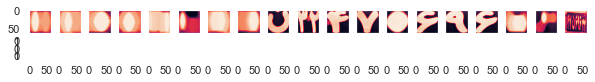

'4 4 4 4 4 2 4 4 9 5 آ 5 9 8 س 8 2 8 2'

In [36]:
fig = plt.figure(figsize=(10., 12.))
grid = ImageGrid(fig, 111, nrows_ncols=(4, len(test_images)), axes_pad=0.1)
for ax, im in zip(grid, test_images):
    ax.imshow(im)

plt.show()

' '.join([image_to_word(image) for image in test_images])